## Adult census income classification

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_predict, learning_curve
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [2]:
df = pd.read_csv('adult.csv')
df['income'] = df['income'].replace('<=50K', 0)
df['income'] = df['income'].replace('>50K', 1)
df.head(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0


In [3]:
# remove missing data
print('original dataframe has ' + str(len(df)) + ' instances')
df = df.replace('?', np.NaN).dropna()
print('after removal, there are ' + str(len(df)) + ' instances')
df.head(10)

original dataframe has 32561 instances
after removal, there are 30162 instances


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,0
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,0
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,1
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,0
10,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States,1
11,38,Self-emp-not-inc,164526,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,2824,45,United-States,1
12,52,Private,129177,Bachelors,13,Widowed,Other-service,Not-in-family,White,Female,0,2824,20,United-States,1


In [4]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income             int64
dtype: object

In [5]:
print('workclass categories: ' + str(df['workclass'].unique()))
# fnlwgt The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian 
# noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau.
print('education categories: ' + str(df['education'].unique()))
print('maritial.status categories: ' + str(df['marital.status'].unique()))
print('occupation categories: ' + str(df['occupation'].unique()))
print('relationship categories: ' + str(df['relationship'].unique()))
print('race categories: ' + str(df['race'].unique()))
print('sex categories: ' + str(df['sex'].unique()))
print('native.country categories: ' + str(df['native.country'].unique()))

workclass categories: ['Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay']
education categories: ['HS-grad' '7th-8th' 'Some-college' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-voc' '1st-4th' '5th-6th' 'Assoc-acdm'
 '12th' '9th' 'Preschool']
maritial.status categories: ['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']
occupation categories: ['Exec-managerial' 'Machine-op-inspct' 'Prof-specialty' 'Other-service'
 'Adm-clerical' 'Transport-moving' 'Sales' 'Craft-repair'
 'Farming-fishing' 'Tech-support' 'Protective-serv' 'Handlers-cleaners'
 'Armed-Forces' 'Priv-house-serv']
relationship categories: ['Not-in-family' 'Unmarried' 'Own-child' 'Other-relative' 'Husband' 'Wife']
race categories: ['White' 'Black' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
sex categories: ['Female' 'Male']
native.country categories: ['United-States' 'Mexico' 'Greece'

In [6]:
# drop features education and relationship
df = df.drop(['education', 'relationship', 'occupation', 'native.country', 'race'], axis = 1)
# df = df.drop(['education', 'relationship', 'workclass', 'native.country', 'race', 'occupation'], axis = 1)
df.head(5)

,age,workclass,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,income
1,82,Private,132870,9,Widowed,Female,0,4356,18,0
3,54,Private,140359,4,Divorced,Female,0,3900,40,0
4,41,Private,264663,10,Separated,Female,0,3900,40,0
5,34,Private,216864,9,Divorced,Female,0,3770,45,0
6,38,Private,150601,6,Separated,Male,0,3770,40,0


In [7]:
# deal with feature race, sex, native.country, occupation
le = LabelEncoder()
# le.fit(df['race'].unique())
# df['race'] = le.transform(df['race'])
le.fit(df['sex'].unique())
df['sex'] = le.transform(df['sex'])
# le.fit(df['native.country'].unique())
# df['native.country'] = le.transform(df['native.country'])
# le.fit(df['occupation'].unique())
# df['occupation'] = le.transform(df['occupation'])
df.head()

,age,workclass,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,income
1,82,Private,132870,9,Widowed,0,0,4356,18,0
3,54,Private,140359,4,Divorced,0,0,3900,40,0
4,41,Private,264663,10,Separated,0,0,3900,40,0
5,34,Private,216864,9,Divorced,0,0,3770,45,0
6,38,Private,150601,6,Separated,1,0,3770,40,0


In [8]:
# deal with feature workclass and marital.status
df['workclass'] = df['workclass'].replace(['State-gov', 'Federal-gov', 'Local-gov'], 'gov')
df['workclass'] = df['workclass'].replace(['Self-emp-not-inc', 'Self-emp-inc'], 'employment')
df['workclass'] = df['workclass'].map({'gov': 0, 'employment': 1, 'Private': 2, 'Without-pay': 3}).astype(np.int64)

df['marital.status'] = df['marital.status'].replace(['Widowed', 'Divorced', 'Separated', 'Never-married'], 'single')
df['marital.status'] = df['marital.status'].replace(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 
                                                    'married')
df['marital.status'] = df['marital.status'].map({'single': 0, 'married': 1}).astype(np.int64)
df.head()

,age,workclass,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,income
1,82,2,132870,9,0,0,0,4356,18,0
3,54,2,140359,4,0,0,0,3900,40,0
4,41,2,264663,10,0,0,0,3900,40,0
5,34,2,216864,9,0,0,0,3770,45,0
6,38,2,150601,6,0,1,0,3770,40,0


In [9]:
# check datatypes
df.dtypes

age               int64
workclass         int64
fnlwgt            int64
education.num     int64
marital.status    int64
sex               int64
capital.gain      int64
capital.loss      int64
hours.per.week    int64
income            int64
dtype: object

In [10]:
# X_df = df.iloc[:, :-1]
# y_df = df.iloc[:, -1]

# X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state = 0)

# svmclf = SVC()
# svmclf.fit(X_train, y_train)
# # y_predict = svmclf.predict(X_test)
# print('svm all features accuracy is ' + str(svmclf.score(X_test, y_test)))


In [11]:
X_df = df.iloc[:, :-1]
# numeric features preserved
X_numeric = df[['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']]
y_df = df.iloc[:, -1]

In [12]:
# from pandas.tools.plotting import scatter_matrix
# scatter_matrix(X_numeric, figsize=(15,11))

In [13]:
# decision tree classifier (to find the 2 highest information gain)
treeclf = DecisionTreeClassifier(criterion = 'entropy')
treeclf.fit(X_df, y_df)
feature_importance_val = treeclf.feature_importances_
features = list(X_numeric.columns)
argfeature = feature_importance_val.argsort()
print('the most important 2 features are ' + str(features[argfeature[-1]]) + ' and ' + str(features[argfeature[-2]]))

the most important 2 features are education.num and capital.loss


In [14]:
rfc = RandomForestClassifier()
y_predict = cross_val_predict(rfc, X_df, y_df, cv = 10)
print('decision tree model report')
print(classification_report(y_predict, y_df))
print('decision tree accuracy is: ' + str(accuracy_score(y_predict, y_df)))

decision tree model report
             precision    recall  f1-score   support

          0       0.88      0.82      0.85     24359
          1       0.42      0.55      0.48      5803

avg / total       0.79      0.77      0.78     30162

decision tree accuracy is: 0.7688813739141966


Text(0,0.5,'training and valid scores')

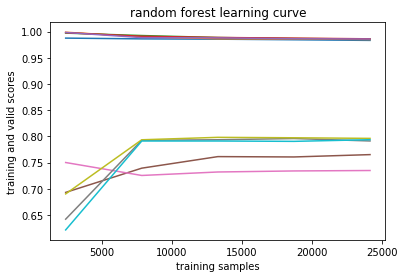

In [15]:
train_sizes, train_scores, valid_scores = learning_curve(RandomForestClassifier(), X_df, y_df, cv = 5)

plt.plot(train_sizes, train_scores)
plt.plot(train_sizes, valid_scores)
plt.title('random forest learning curve')
plt.xlabel('training samples')
plt.ylabel('training and valid scores')

Text(0,0.5,'training and valid scores')

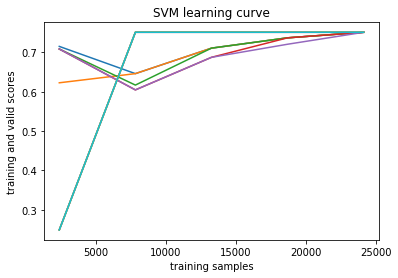

In [16]:
%%time
train_sizes, train_scores, valid_scores = learning_curve(SVC(C = 0.01), X_df, y_df, cv = 5)

plt.plot(train_sizes, train_scores)
plt.plot(train_sizes, valid_scores)
plt.title('SVM learning curve')
plt.xlabel('training samples')
plt.ylabel('training and valid scores')

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X_numeric, y_df, random_state = 0)

# svmclf = SVC()
# svmclf.fit(X_train, y_train)
# # y_predict = svmclf.predict(X_test)
# print('svm all numeric features accuracy is ' + str(svmclf.score(X_test, y_test)))

<Figure size 432x288 with 0 Axes>

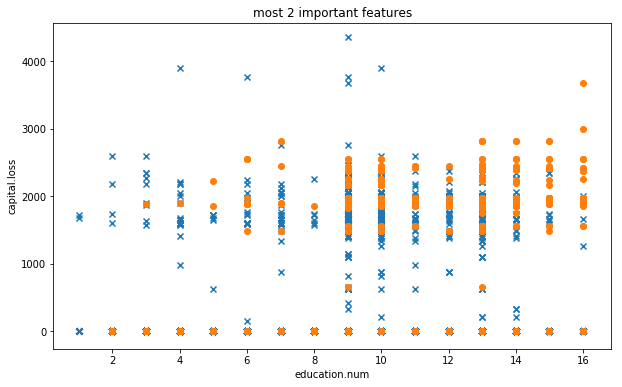

In [18]:
most2_df = df[[features[argfeature[-1]], features[argfeature[-2]], 'income']]
X_most2 = most2_df.iloc[:, :-1]
plt.clf()
plt.figure(figsize = (10, 6))

colors = ['b','r']
names = [0, 1]

bucket = most2_df[(most2_df['income'] == 0)]
bucket = bucket.iloc[:, :-1].values
plt.scatter(bucket[:, 0], bucket[:, 1], label = 'income < 50K', marker = 'x') 

bucket = most2_df[(most2_df['income'] == 1)]
bucket = bucket.iloc[:, :-1].values
plt.scatter(bucket[:, 0], bucket[:, 1], label = 'income > 50K') 

plt.title('most 2 important features')
plt.xlabel(list(X_most2)[0])
plt.ylabel(list(X_most2)[1])
plt.show()

plt.show()

In [12]:
i = 150
X_most2 = X_df[['fnlwgt', 'marital.status']]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


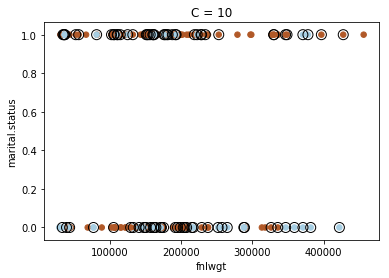

Wall time: 7.15 s


In [13]:
%%time
clf = SVC(kernel = 'linear', C = 10)
clf.fit(X_most2[:i], y_df[:i])

plt.scatter(X_most2.iloc[:i, 0], X_most2.iloc[:i, 1], c = y_df[:i], s = 30, cmap = plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.title('C = 10')
plt.xlabel(list(X_most2)[0])
plt.ylabel(list(X_most2)[1])
plt.show()

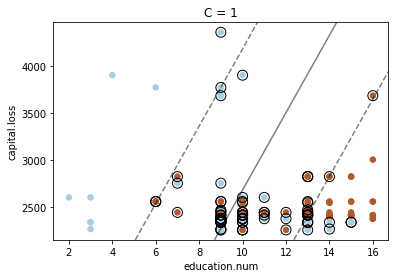

Wall time: 572 ms


In [21]:
%%time
clf = SVC(kernel = 'linear', C = 1)
clf.fit(X_most2[:i], y_df[:i])
plt.scatter(X_most2.iloc[:i, 0], X_most2.iloc[:i, 1], c = y_df[:i], s = 30, cmap = plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.title('C = 1')
plt.xlabel(list(X_most2)[0])
plt.ylabel(list(X_most2)[1])
plt.show()

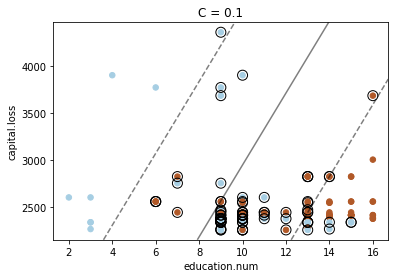

Wall time: 200 ms


In [22]:
%%time
clf = SVC(kernel = 'linear', C = 0.1)
clf.fit(X_most2[:i], y_df[:i])
plt.scatter(X_most2.iloc[:i, 0], X_most2.iloc[:i, 1], c = y_df[:i], s = 30, cmap = plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.title('C = 0.1')
plt.xlabel(list(X_most2)[0])
plt.ylabel(list(X_most2)[1])
plt.show()

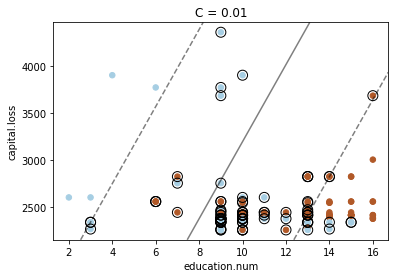

Wall time: 89 ms


In [23]:
%%time
clf = SVC(kernel = 'linear', C = 0.01)
clf.fit(X_most2[:i], y_df[:i])
plt.scatter(X_most2.iloc[:i, 0], X_most2.iloc[:i, 1], c = y_df[:i], s = 30, cmap = plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.title('C = 0.01')
plt.xlabel(list(X_most2)[0])
plt.ylabel(list(X_most2)[1])
plt.show()

In [24]:
skf = StratifiedKFold(n_splits = 10, random_state = 0)
train_fold = []
test_fold = []
for train, test in skf.split(X_most2, y_df):
    train_fold.append(train)
    test_fold.append(test)
    print("TRAIN:", train, "TEST:", test)
len(train)

TRAIN: [ 1441  1442  1443 ... 30159 30160 30161] TEST: [   0    1    2 ... 4747 4748 4750]
TRAIN: [    0     1     2 ... 30159 30160 30161] TEST: [1441 1442 1443 ... 7581 7582 7583]
TRAIN: [    0     1     2 ... 30159 30160 30161] TEST: [ 2204  2205  2206 ... 10382 10383 10384]
TRAIN: [    0     1     2 ... 30159 30160 30161] TEST: [ 3466  3467  3468 ... 13195 13196 13197]
TRAIN: [    0     1     2 ... 30159 30160 30161] TEST: [ 7323  7328  7337 ... 16014 16015 16016]
TRAIN: [    0     1     2 ... 30159 30160 30161] TEST: [11198 11200 11201 ... 18846 18847 18848]
TRAIN: [    0     1     2 ... 30159 30160 30161] TEST: [15106 15110 15121 ... 21647 21648 21650]
TRAIN: [    0     1     2 ... 30159 30160 30161] TEST: [18857 18863 18866 ... 24491 24492 24493]
TRAIN: [    0     1     2 ... 30159 30160 30161] TEST: [22716 22720 22736 ... 27345 27347 27349]
TRAIN: [    0     1     2 ... 27345 27347 27349] TEST: [26405 26409 26410 ... 30159 30160 30161]


27147

In [31]:
%%time
grid_values = {'C': [0.01, 0.1, 1, 10], 'kernel': ['rbf']}
svc = SVC()
clf = GridSearchCV(svc, param_grid = grid_values, scoring = 'accuracy', cv = 10)
clf.fit(X_most2, y_df)
print("Best parameters set found on development set: ")
print()
print(clf.best_params_)
#  best parameter C = 0.01

Best parameters set found on development set: 

{'C': 0.01, 'kernel': 'rbf'}
Wall time: 9min 6s


In [32]:
clf.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([8.32566502, 7.37573304, 6.80148149, 7.20360274]),
 'std_fit_time': array([0.57268035, 0.38737262, 0.2166496 , 0.13563574]),
 'mean_score_time': array([0.70922439, 0.61095576, 0.55261824, 0.54822452]),
 'std_score_time': array([0.15912064, 0.17246674, 0.19057904, 0.19038684]),
 'param_C': masked_array(data=[0.01, 0.1, 1, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'rbf'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01, 'kernel': 'rbf'},
  {'C': 0.1, 'kernel': 'rbf'},
  {'C': 1, 'kernel': 'rbf'},
  {'C': 10, 'kernel': 'rbf'}],
 'split0_test_score': array([0.72555519, 0.72555519, 0.72555519, 0.72555519]),
 'split1_test_score': array([0.81206497, 0.81206497, 0.81206497, 0.81206497]),
 'split2_test_score': array([0.76599271, 0.76599271, 0.76599271, 0.76599271]),
 'split3_te

In [ ]:
# X_train, X_test = X_df.iloc[train_fold[0]], X_df.iloc[test_fold[0]]
# y_train, y_test = y_df.iloc[train_fold[0]], y_df.iloc[test_fold[0]]
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state = 1)

In [ ]:
%%time

svmclf1 = LinearSVC(C = 0.01)
svmclf1.fit(X_train, y_train)
y_predict = cross_val_predict(svmclf1, X_df, y_df, cv = 10)
# y_predict = svmclf1.predict(X_test)
# print('accuracy of linear kernel (training error)is ' + str(svmclf.score(X_train, y_train)))
print('linear model report')
print(classification_report(y_predict, y_df))
print('linear accuracy is: ' + str(accuracy_score(y_predict, y_df)))

In [ ]:
%%time
# X_train, X_test, y_train, y_test = train_test_split(X_most2, y_df, random_state = 1)
svmclf2 = SVC(kernel = 'rbf', C = 0.01)
# svmclf2.fit(X_train, y_train)
y_predict = cross_val_predict(svmclf2, X_df, y_df, cv = 10)
# y_predict = svmclf2.predict(X_test)

print('rbf model report')
print(classification_report(y_predict, y_df))
print('rbf accuracy is: ' + str(accuracy_score(y_predict, y_df)))

In [ ]:

# # # X_train, X_test, y_train, y_test = train_test_split(X_most2, y_df, random_state = 1)
# svmclf3 = SVC(C = 0.01)
# poly = PolynomialFeatures(degree = 2)
# X_train_poly = poly.fit_transform(X_train)
# X_test_poly = poly.fit_transform(X_test)

# # svmclf3.fit(X_train, y_train)
# svmclf3.fit(X_train_poly, y_train)
# y_predict = svmclf3.predict(X_test_poly)
# print('polynomial model report')
# print(classification_report(y_predict, y_test))
# print('polynomial accuracy is: ' + str(accuracy_score(y_predict, y_test)))

In [ ]:
X_most2['power1'] = np.power(X_most2[list(X_most2.columns)[0]], 2)
X_most2['power2'] = np.power(X_most2[list(X_most2.columns)[1]], 2)
X_train, X_test, y_train, y_test = train_test_split(X_most2, y_df, random_state = 1)
svmclf4 = LinearSVC(C = 0.01)
svmclf4.fit(X_train, y_train)
y_predict = cross_val_predict(svmclf4, X_df, y_df, cv = 10)
print('polynomial model report')
print(classification_report(y_predict, y_df))
print('polynomial accuracy is: ' + str(accuracy_score(y_predict, y_df)))

In [ ]:
# %%time
# # X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state = 1)
svmclf3 = LinearSVC(C = 0.01)
poly = PolynomialFeatures(degree = 2)
# X_poly = poly.fit_transform(X_df)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

# # %%time
svmclf3.fit(X_train_poly, y_train)

# y_predict = cross_val_predict(svmclf3, X_poly, y_df, cv = 10)
y_predict = svmclf3.predict(X_test_poly)
print('poly kernel model report')
print(classification_report(y_predict, y_df))
print('poly kernel accuracy is: ' + str(accuracy_score(y_predict, y_df)))
# print('accuracy of polynomial kernel (training error)is ' + str(svmclf.score(X_train, y_train)))
# print('accuracy of polynomial kernel (test error) is ' + str(accuracy_score(y_predict, y_test)))
# print('precision of polynomial kernel is ' + str(precision_score(y_test, y_predict)))  
# print('recall of polynomial kernel is ' + str(recall_score(y_test, y_predict)))
# print('f1_score of polynomial kernel is ' + str(f1_score(y_test, y_predict)))
# confusion_matrix(y_test, y_predict)